---
title: "GPA Analysis"
author: "Brandon Scott"
date: "2022-12-24"
categories: [analysis, bayesian]
draft: false
format:
    html:
        code-fold: true
jupyter: python3
---

# Analysis of relationship between GPA and # study hours

## Abstract

The hope of this analysis is to demonstratet that there is a quantifiable relationship between GPA and study hours. We recognize that the collected data was self reported and therefore can be dishonest. Nonetheless, our goal is to still find a way to quantify a relationship between GPA and study hours to:
1. Gather inference to determine how GPA changes based on increase study time
2. Predict what a student's GPA would be based on study time

## Setup Analysis

We begin our analysis by importing the following libraries to create data visualizations as well as properly format and filter our data.

In [1]:
#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/joebeachcapital/gpa-study-hours")

100%|█████████████████████████████████| 658/658 [00:00<00:00, 21.0kB/s]

In [3]:
#Create dataframe from file
df = pd.read_csv("kaggle_datasets//gpa-study-hours/gpa_study_hours.csv")

In [4]:
#Check dataframe
df.head()

,gpa,study_hours
0,4.00,10.0
1,3.80,25.0
2,3.93,45.0
3,3.40,10.0
4,3.20,4.0


## Data Cleaning

In [5]:
#Describe dataset
df.describe()

,gpa,study_hours
count,193.000000,193.000000
mean,3.586166,17.476684
std,0.285482,11.408980
min,2.600000,2.000000
25%,3.400000,10.000000
50%,3.620000,15.000000
75%,3.800000,20.000000
max,4.300000,69.000000


In [6]:
#Check datatypes
df.dtypes

gpa            float64
study_hours    float64
dtype: object

In [7]:
#Check for null values
df.isnull().sum()

gpa            0
study_hours    0
dtype: int64

In [8]:
#Convert outlier GPA (erroneous entries) to 4.0
df = df.assign(gpa = lambda x: np.where(x.gpa > 4, 4, x.gpa))

## EDA

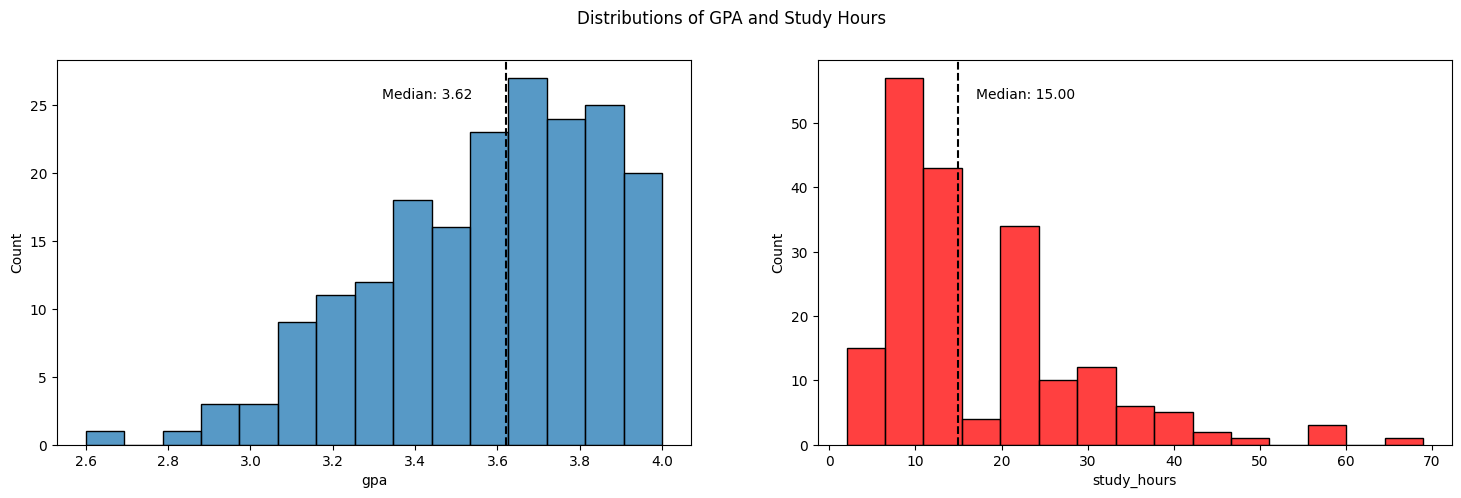

In [9]:
# Check distributios of gpa and study hours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))
sns.histplot(x="gpa", data=df, ax=ax1, bins=15)
ax1.axvline(df.gpa.median(), color="black", linestyle="dashed")
ax1.text(df.gpa.median() - 0.3, ax1.get_ylim()[1] * 0.9, f"Median: {df.gpa.median():.2f}")

sns.histplot(x="study_hours", data=df, ax=ax2, color="red", bins=15)
ax2.axvline(df.study_hours.median(), color="black", linestyle="dashed")
ax2.text(df.study_hours.median() + 2, ax2.get_ylim()[1] * 0.9, f"Median: {df.study_hours.median():.2f}")

fig.suptitle("Distributions of GPA and Study Hours");

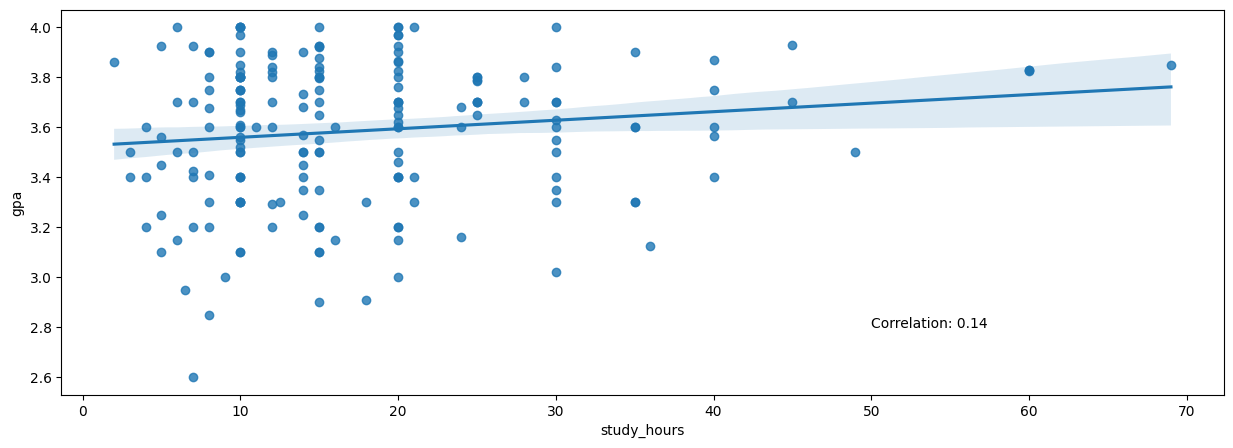

In [10]:
#Scatterplot of gpa and study hours
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df)
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
plt.text(50, 2.8, f"Correlation: {corr_coef:.2f}");

In [11]:
#Identify outliers
def find_outliers(x, column_name):
    q1 = x[column_name].quantile(.25)
    q3 = x[column_name].quantile(.75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    outliers = x[(x[column_name] < lower) | (x[column_name] > upper)]
    
    return outliers
    

In [12]:
#Find outliers for gpa
find_outliers(df, "gpa")

,gpa,study_hours
108,2.6,7.0


In [16]:
#Find outliers for study hours
find_outliers(df, "study_hours")["study_hours"].min()

36.0

In [18]:
#Remove outliers from dataset
df = df.query("gpa > 2.6 and study_hours < 36")

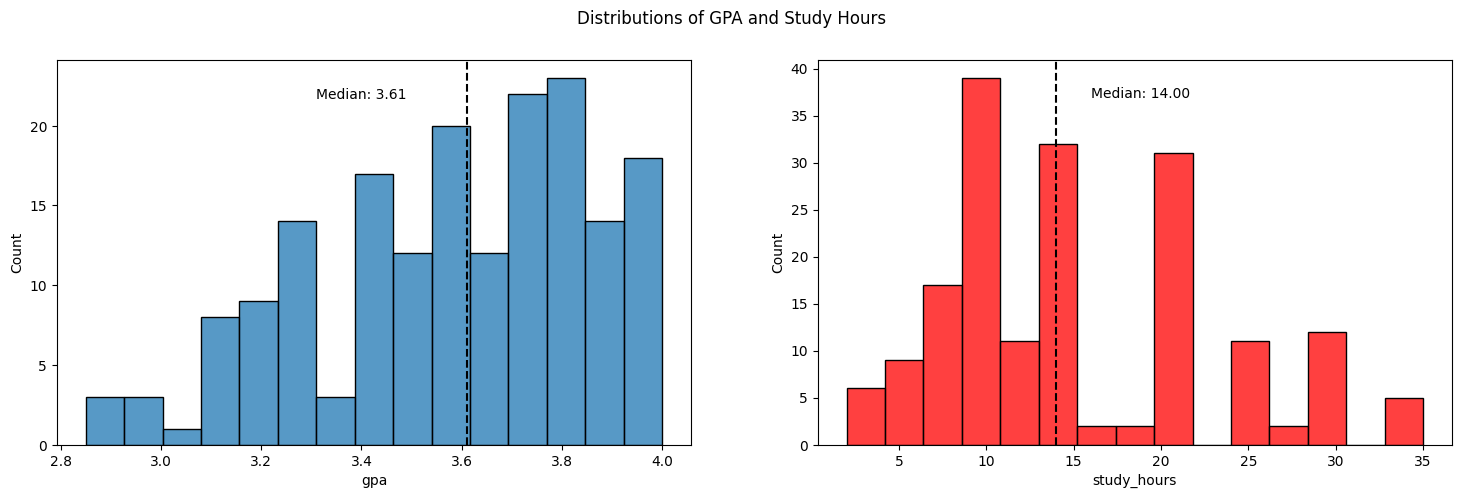

In [19]:
#Revisualize distributions without outliers
# Check distributios of gpa and study hours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))
sns.histplot(x="gpa", data=df, ax=ax1, bins=15)
ax1.axvline(df.gpa.median(), color="black", linestyle="dashed")
ax1.text(df.gpa.median() - 0.3, ax1.get_ylim()[1] * 0.9, f"Median: {df.gpa.median():.2f}")

sns.histplot(x="study_hours", data=df, ax=ax2, color="red", bins=15)
ax2.axvline(df.study_hours.median(), color="black", linestyle="dashed")
ax2.text(df.study_hours.median() + 2, ax2.get_ylim()[1] * 0.9, f"Median: {df.study_hours.median():.2f}")

fig.suptitle("Distributions of GPA and Study Hours");

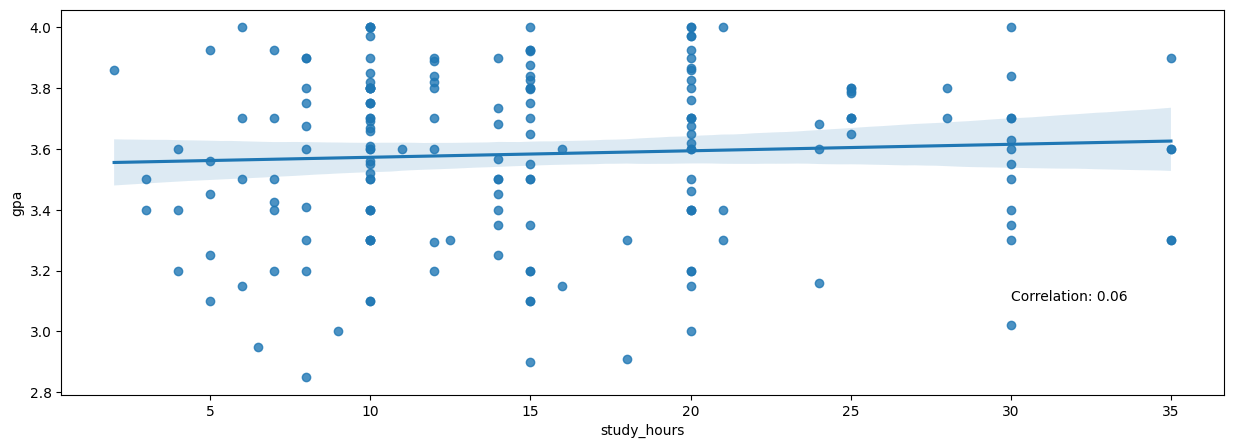

In [23]:
#Revisit scatterplot
plt.figure(figsize=(15,5))
sns.regplot(x='study_hours', y='gpa', data=df)
corr_coef = np.corrcoef(df.study_hours, df.gpa)[0][1]
plt.text(30, 3.1, f"Correlation: {corr_coef:.2f}");